# DML Diff-in-Diff


In [56]:
import numpy as np
import pandas as pd
import doubleml as dml
import multiprocessing
import seaborn as sns

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## Repeated Outcomes

We will focus on the the DGP1 from [Sant'Anna and Zhao (2020)](https://arxiv.org/abs/1812.01723), see Section 4.1 and 4.2.

In [57]:
def f_reg(Z):
  res = 210 + 27.4*Z[:, 0] + 13.7*(Z[:, 1] + Z[:, 2] + Z[:, 3])
  return res

def f_ps(Z):
  res = 0.75*(-Z[:, 0] + 0.5*Z[:, 1] - 0.25*Z[:, 2] - 0.1*Z[:, 3])
  return res

def dgp(n=200, dgp_type=1):
  # features
  X = np.random.normal(loc=0, scale=1, size=[n,4])
  Z_tilde_1 = np.exp(0.5*X[:, 0])
  Z_tilde_2 = 10 + X[:, 1] / (1 + np.exp(X[:, 0]))
  Z_tilde_3 = (0.6 + X[:, 0]*X[:, 2]/25)**3
  Z_tilde_4 = (20 + X[:, 1] + X[:, 3])**2

  Z_tilde = np.column_stack((Z_tilde_1, Z_tilde_2, Z_tilde_3, Z_tilde_4))
  Z = (Z_tilde - np.mean(Z_tilde, axis=0)) / np.std(Z_tilde, axis=0)
  
  # error terms
  epsilon_0 = np.random.normal(loc=0, scale=1, size=n)
  epsilon_1 = np.random.normal(loc=0, scale=1, size=[n,2])
  if dgp_type == 1:
    features_ps = Z
    features_reg = Z
  elif dgp_type == 2:
    features_ps = X
    features_reg = Z
  elif dgp_type == 3:
    features_ps = Z
    features_reg = X
  elif dgp_type == 4:
    features_ps = X
    features_reg = X
  else:
    ValueError("DGP type not specified")

  # treatment and propensities
  p = np.exp(f_ps(features_ps)) / (1 + np.exp(f_ps(features_ps)))
  U = np.random.uniform(low=0, high=1, size=n)
  D = 1.0 * (p >= U)

  # potential outcomes
  nu =  np.random.normal(loc=D*f_reg(features_reg), scale=1, size=n)
  Y0 = f_reg(features_reg) + nu + epsilon_0
  Y1_d0 = 2*f_reg(features_reg) + nu + epsilon_1[:, 0]
  Y1_d1 = 2*f_reg(features_reg) + nu + epsilon_1[:, 1]
  Y1 = D*Y1_d1 + (1-D)*Y1_d0

  return Y0, Y1, D, Z, Y1_d0, Y1_d1


The ATT should be zero:

In [58]:
dgp_type = 4
_, _, D, _, Y1_d0, Y1_d1 = dgp(int(10e+6), dgp_type=dgp_type)

ATT = np.mean(Y1_d1[D == 1] - Y1_d0[D == 1])
print(f'Observed ATT: {ATT}')

Observed ATT: 0.0003696334225408699


In [59]:
np.random.seed(42)
n_rep = 100
n_obs = 1000
lambda_T = 0.5

datasets_ro = []
datasets_rcs = []
for i in range(n_rep):
    Y0, Y1, D, X, _, _ = dgp(n=n_obs, dgp_type=dgp_type)

    # datasets with repeated outcomes (ro)
    Y_diff = Y1 - Y0
    data_ro =  dml.DoubleMLData.from_arrays(X, Y_diff, D)  
    datasets_ro.append(data_ro)

    # datasets with repeated cross sections
    U_T = np.random.uniform(low=0, high=1, size=n_obs)
    T = 1.0 * (U_T <= lambda_T)
    Y_obs = T * Y1 + (1-T)*Y0
    data_rcs = dml.DoubleMLDIDData.from_arrays(X, Y_obs, D, T)
    datasets_rcs.append(data_rcs)

In [60]:
ml_g = RandomForestRegressor(n_estimators=50)
ml_m = RandomForestClassifier(n_estimators=50)

n_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {n_cores}")
# to be process folds in parallel
cores_used = 5

Number of Cores: 8


In [61]:
# set core to repeated outcomes
score = "RO"

coefs = np.full((n_rep), np.nan)
ses = np.full((n_rep), np.nan)
cover = np.full((n_rep), np.nan)
ci_length = np.full((n_rep), np.nan)

for i_rep in range(n_rep):
    print(i_rep)
    obj_dml_data = datasets_ro[i_rep]
    dml_DiD = dml.DoubleMLDID(obj_dml_data, 
                              ml_g=clone(ml_g),
                              ml_m=clone(ml_m),
                              score=score,
                              n_folds=5)

    dml_DiD.fit(n_jobs_cv=cores_used)

    # save coefs and ses
    coefs[i_rep] = dml_DiD.coef
    ses[i_rep] = dml_DiD.se

    # calculate confidence interval
    confint = dml_DiD.confint(level=0.95)
    cover[i_rep] = (confint['2.5 %'] < ATT) & (ATT < confint['97.5 %'])
    ci_length[i_rep] = confint['97.5 %'] - confint['2.5 %']

0


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


1
2


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


3
4
5


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


6


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


7


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


8


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


9


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


10


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


11


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


12


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


13


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


14


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


15


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


16
17


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


18


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


19


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


20


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


21


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


22


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


23


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


24


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


25


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


26


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


27


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


28


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


29


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


30


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


31


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


32


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


33


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


34


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


35


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


36


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


37


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


38


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


39


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


40


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


41


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


42


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


43


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


44


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


45


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


46


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


47


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


48
49


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


50


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


51


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


52


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


53


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


54


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


55


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


56


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


57


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


58


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


59


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


60


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


61


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


62


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


63


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


64
65


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


66


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


67


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


68


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


69


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


70


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


71


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


72


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


73


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


74
75


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


76


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


77


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


78


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


79


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


80


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


81


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


82


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


83


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


84


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


85


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


86


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


87


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


88


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


89


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


90


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


91


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


92


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


93


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


94


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


95


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


96
97


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


98


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


99


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


In [62]:
print(f'Avg. Bias: {coefs.mean()}')
print(f'Avg. asymptotic Variance: {np.square(ses).mean()}')
print(f'Coverage: {cover.mean()}')
print(f'Avg. CI length: {ci_length.mean()}')

Avg. Bias: 1.0986198264028149
Avg. asymptotic Variance: 6.029983629152161
Coverage: 0.98
Avg. CI length: 8.45144303389483


Save the estimates to compare this to repeated cross-sectional data.

In [68]:
data_plot = {"Repeated Outcomes": coefs}
df_plot = pd.DataFrame(data_plot)

## Repeated Cross-sectional Data

Use the same data with coss-sectional observations

In [64]:
# set core to repeated outcomes
score = "RCS"

coefs = np.full((n_rep), np.nan)
ses = np.full((n_rep), np.nan)
cover = np.full((n_rep), np.nan)

for i_rep in range(n_rep):
    print(i_rep)
    obj_dml_data = datasets_rcs[i_rep]
    dml_DiD = dml.DoubleMLDID(obj_dml_data, 
                              ml_g=clone(ml_g),
                              ml_m=clone(ml_m),
                              score=score,
                              n_folds=5)

    dml_DiD.fit(n_jobs_cv=cores_used)

    # save coefs and ses
    coefs[i_rep] = dml_DiD.coef
    ses[i_rep] = dml_DiD.se

    # calculate confidence interval
    confint = dml_DiD.confint(level=0.95)
    cover[i_rep] = (confint['2.5 %'] < ATT) & (ATT < confint['97.5 %'])

0


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


1


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


2


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


3


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


4


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


5


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


6


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


7


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


8


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


9


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


10


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


11


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


12


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


13


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


14


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


15


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


16
17


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


18


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


19


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


20


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


21


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


22


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


23
24


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


25


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


26


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


27


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


28


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


29


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


30


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


31


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


32


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


33


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


34


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


35


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


36


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


37


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


38


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


39


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


40


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


41


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


42


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


43


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


44


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


45


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


46


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


47


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


48


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


49


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


50


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


51


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


52


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


53


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


54


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


55


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


56


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


57


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


58


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


59


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


60


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


61


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


62


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


63


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


64


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


65


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


66


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


67


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


68


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


69


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


70
71


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


72


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


73


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


74


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


75


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


76


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


77


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


78
79


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


80


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


81
82


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


83
84


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


85


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


86
87


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


88


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


89


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


90


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


91


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


92


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


93


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


94
95


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


96


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


97


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


98


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


99


c:\users\bam5698\github\doubleml-for-py\doubleml\_utils.py:252: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=50) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


In [65]:
print(f'Avg. Bias: {coefs.mean()}')
print(f'Avg. asymptotic Variance: {np.square(ses).mean()}')
print(f'Coverage: {cover.mean()}')
print(f'Avg. CI length: {ci_length.mean()}')

Avg. Bias: -2.1395153047709154
Avg. asymptotic Variance: 378.11274549138346
Coverage: 1.0
Avg. CI length: 8.45144303389483


In [66]:
df_plot['Repeated Cross-Sections'] = coefs
df_density = pd.melt(df_plot, value_name='Estimated ATT', var_name='Type')

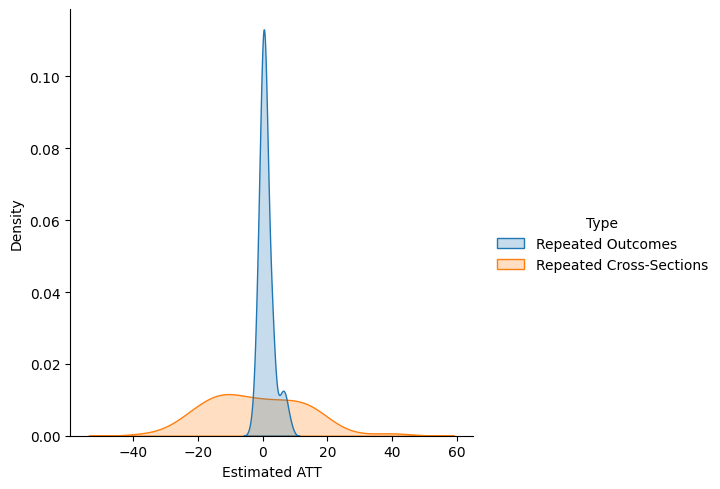

In [67]:
sns.displot(df_density, x="Estimated ATT", hue="Type", kind="kde", fill=True)